In [1]:
!pip install onnx onnxruntime pyserial

     |████████████████████████████████| 12.3 MB 8.2 MB/s 
     |████████████████████████████████| 4.5 MB 52.5 MB/s 
     |████████████████████████████████| 90 kB 7.0 MB/s 


In [2]:
!git clone https://github.com/Tianxiaomo/pytorch-YOLOv4

Cloning into 'pytorch-YOLOv4'...
remote: Enumerating objects: 917, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 917 (delta 0), reused 0 (delta 0), pack-reused 914
Receiving objects: 100% (917/917), 2.34 MiB | 5.60 MiB/s, done.
Resolving deltas: 100% (557/557), done.


In [6]:
%cd pytorch-YOLOv4

/content/pytorch-YOLOv4


In [4]:
!pip install opencv-python==4.4.0.42 --force-reinstall

     |████████████████████████████████| 49.4 MB 92 kB/s 
     |████████████████████████████████| 15.7 MB 326 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
from google.colab.patches import cv2_imshow

In [6]:
import cv2
import time
import numpy as np

CONFIDENCE_THRESHOLD = 0.4
NMS_THRESHOLD = 0.5

In [7]:
class_names = []
with open("coco.names", "r") as f:
    class_names = [cname.strip() for cname in f.readlines()]

In [8]:
img = cv2.imread("fivepercento.jpg")

In [9]:
colors = np.random.uniform(0,255,size=(len(class_names),3))

In [10]:
!gdown --id 1XwtHTwn5mkS-Lqdn80PcULNyK-gmpEEm

Downloading...
From: https://drive.google.com/uc?id=1XwtHTwn5mkS-Lqdn80PcULNyK-gmpEEm
To: /content/pytorch-YOLOv4/yolov4-csp.cfg
100% 13.2k/13.2k [00:00<00:00, 12.3MB/s]


In [11]:
!gdown --id 1FCGAQsBADMPdyfmZrOsSDeneikGWcnlu

Downloading...
From: https://drive.google.com/uc?id=1FCGAQsBADMPdyfmZrOsSDeneikGWcnlu
To: /content/pytorch-YOLOv4/yolov4-csp.weights
212MB [00:04, 43.5MB/s]


In [12]:
net = cv2.dnn.readNet("yolov4-csp.weights", "yolov4-csp.cfg")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

In [13]:
model = cv2.dnn_DetectionModel(net)
model.setInputParams(size=(640, 640), scale=1/255, swapRB=True)

In [14]:
classes, scores, boxes = model.detect(img, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)

In [15]:
for (classid, score, box) in zip(classes, scores, boxes):
  color=colors[classid[0]]
  label = "%s : %f" % (class_names[classid[0]], score)
  cv2.rectangle(img, box,color, 2)
  cv2.putText(img, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255), 2)

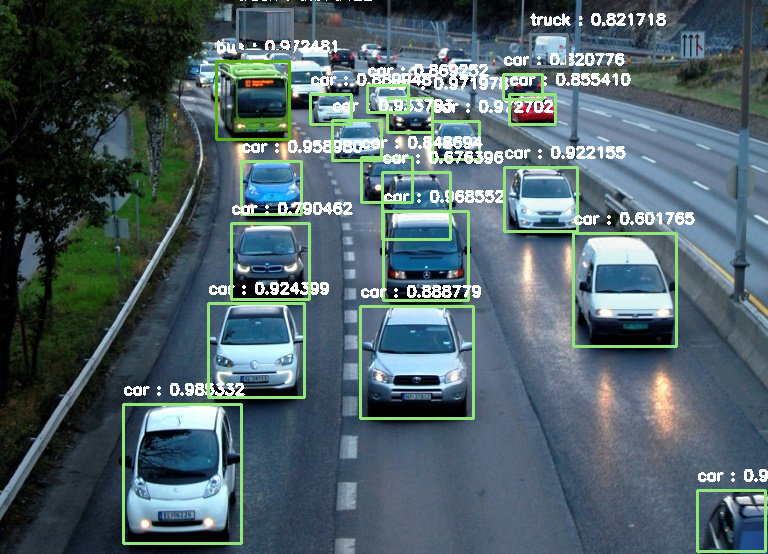

In [16]:
cv2_imshow(img)

In [17]:
!python demo_darknet2onnx.py yolov4-csp.cfg yolov4-csp.weights fivepercento.jpg 0

Converting to onnx and running demo ...
convalution havn't activate linear
convalution havn't activate linear
convalution havn't activate linear
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   512 x 512 x   3   ->   512 x 512 x  32
    1 conv     64  3 x 3 / 2   512 x 512 x  32   ->   256 x 256 x  64
    2 conv     64  1 x 1 / 1   256 x 256 x  64   ->   256 x 256 x  64
    3 route  1
    4 conv     64  1 x 1 / 1   256 x 256 x  64   ->   256 x 256 x  64
    5 conv     32  1 x 1 / 1   256 x 256 x  64   ->   256 x 256 x  32
    6 conv     64  3 x 3 / 1   256 x 256 x  32   ->   256 x 256 x  64
    7 shortcut 4
    8 conv     64  1 x 1 / 1   256 x 256 x  64   ->   256 x 256 x  64
    9 route  8 2
   10 conv     64  1 x 1 / 1   256 x 256 x 128   ->   256 x 256 x  64
   11 conv    128  3 x 3 / 2   256 x 256 x  64   ->   128 x 128 x 128
   12 conv     64  1 x 1 / 1   128 x 128 x 128   ->   128 x 128 x  64
   13 route  11
   14 conv     64  1 x 

In [1]:
pip install onnx onnxruntime

In [7]:
import json
import sys
import os
import time
import numpy as np
import cv2
import onnx
import onnxruntime
from onnx import numpy_helper
import math
import itertools
import struct  # get_image_size
import imghdr
from google.colab.patches import cv2_imshow

In [14]:
from onnxhelp import *

In [15]:
def detect(session, image_src):
    IN_IMAGE_H = session.get_inputs()[0].shape[2]
    IN_IMAGE_W = session.get_inputs()[0].shape[3]

    # Input
    resized = cv2.resize(image_src, (IN_IMAGE_W, IN_IMAGE_H), interpolation=cv2.INTER_LINEAR)
    img_in = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    img_in = np.transpose(img_in, (2, 0, 1)).astype(np.float32)
    img_in = np.expand_dims(img_in, axis=0)
    img_in /= 255.0
    print("Shape of the network input: ", img_in.shape)

    # Compute
    input_name = session.get_inputs()[0].name

    outputs = session.run(None, {input_name: img_in})

    boxes = post_processing(img_in, 0.4, 0.6, outputs)
    namesfile = "coco.names"
    class_names = load_class_names(namesfile)
    infered_frame = plot_boxes_cv2(image_src, boxes[0], class_names=class_names)
    return infered_frame

In [16]:
onnx_path = "yolov4_-1_3_512_512_dynamic.onnx"
session = onnxruntime.InferenceSession(onnx_path)
frame = cv2.imread("fivepercento.jpg")
infered = detect(session,frame)

Shape of the network input:  (1, 3, 512, 512)
car: 0.986317
car: 0.975367
car: 0.969224
car: 0.969160
car: 0.967004
car: 0.962723
car: 0.957695
car: 0.957665
car: 0.948233
car: 0.902866
car: 0.882307
car: 0.839005
car: 0.823450
car: 0.821085
car: 0.790000
car: 0.706938
car: 0.696883
car: 0.641258
car: 0.619207
bus: 0.891306
truck: 0.954524
truck: 0.698964


In [17]:
IN_IMAGE_H = session.get_inputs()[0].shape[2]
IN_IMAGE_W = session.get_inputs()[0].shape[3]

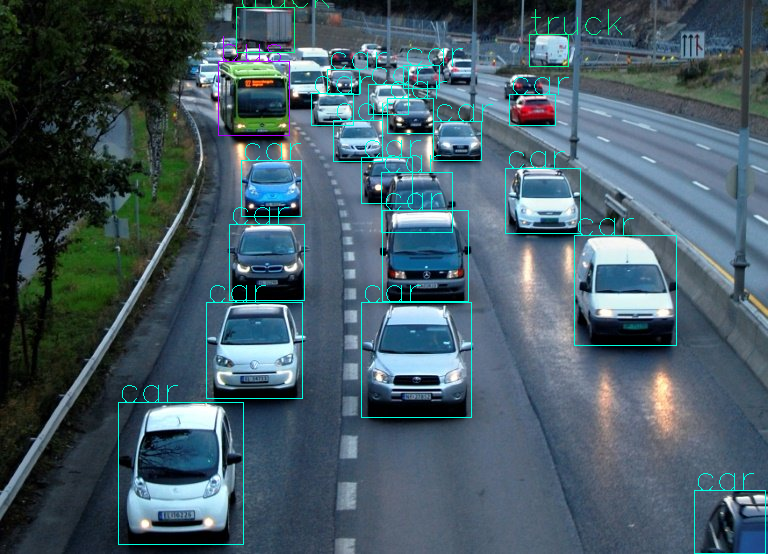

In [18]:
cv2_imshow(infered) 